In [1]:
pip install shapely


Note: you may need to restart the kernel to use updated packages.


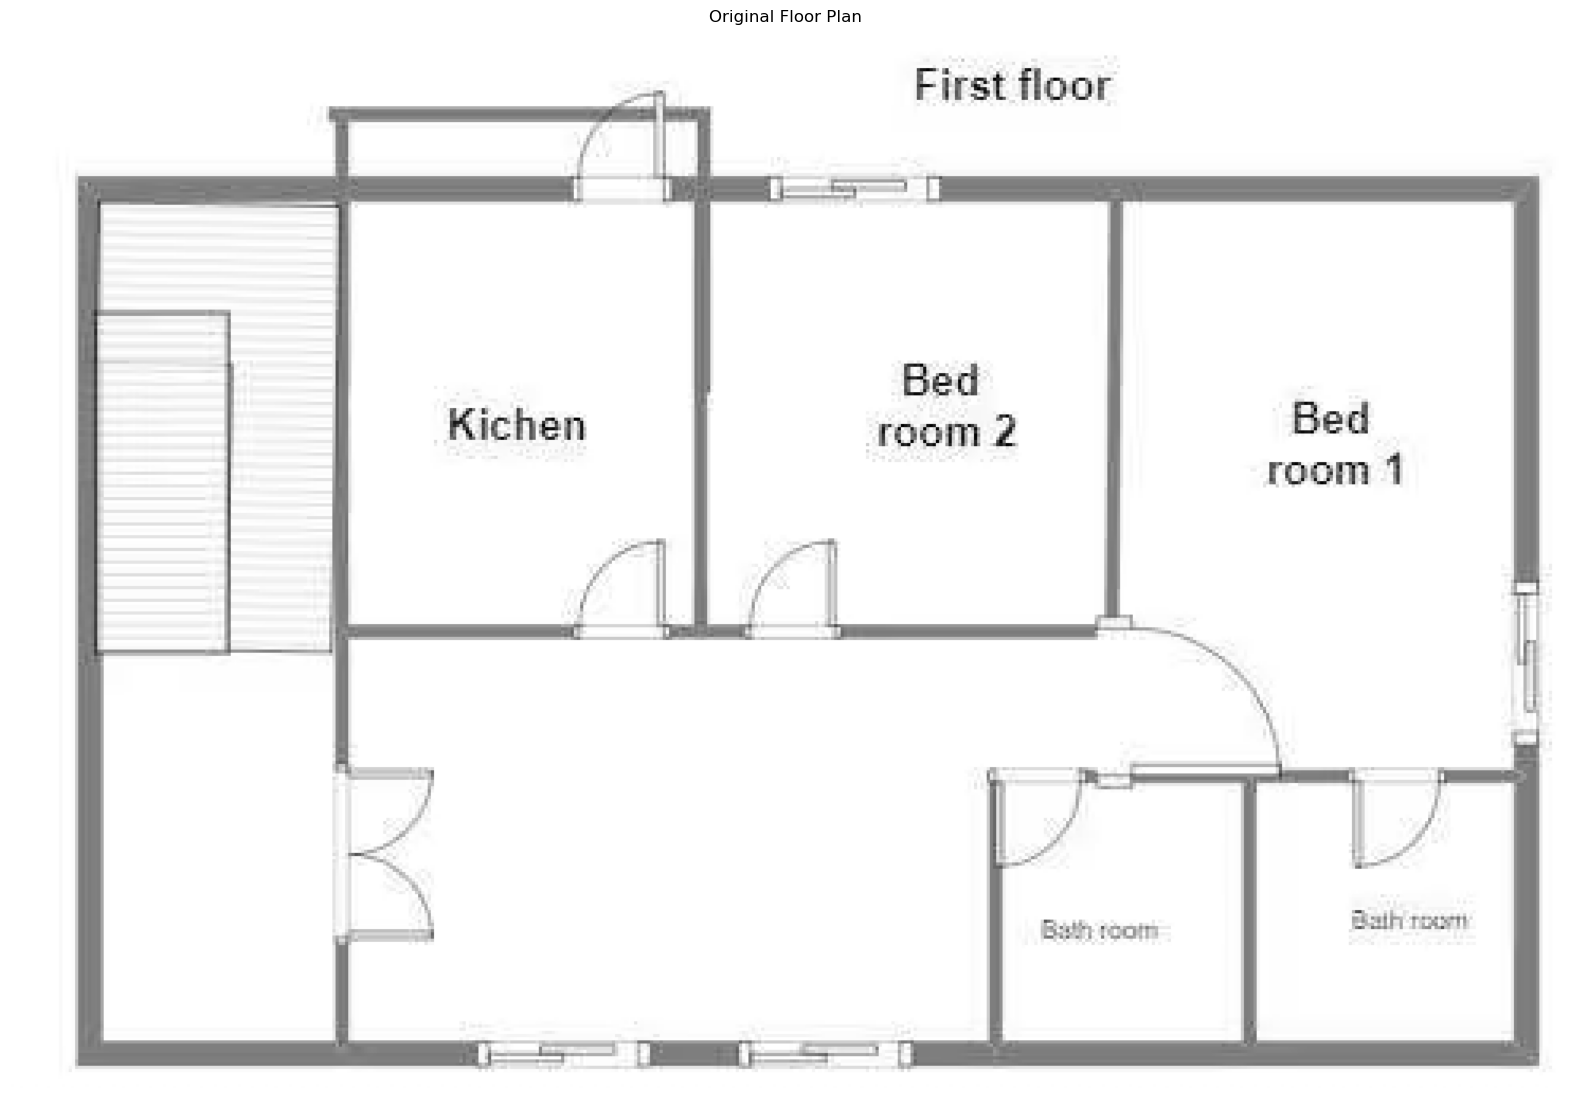

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the image
img = cv2.imread("data/simple_floor_plan.png")  # adjust path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.title("Original Floor Plan")
plt.axis("off")
plt.show()


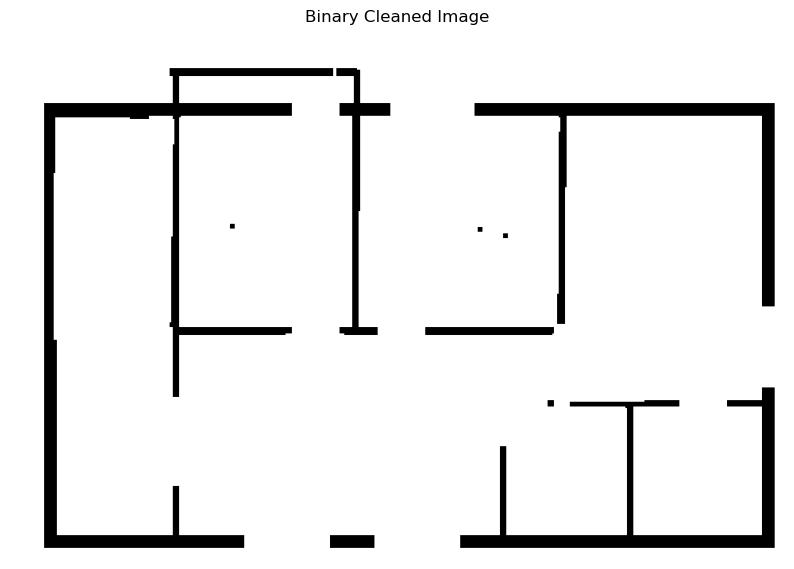

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu thresholding (auto adaptive)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure walls = white, background = black
# If inverted, use bitwise_not()
if np.mean(bw) < 127:
    bw = cv2.bitwise_not(bw)

# Clean up with morphology
kernel = np.ones((3, 3), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.imshow(bw_clean, cmap="gray")
plt.title("Binary Cleaned Image")
plt.axis("off")
plt.show()


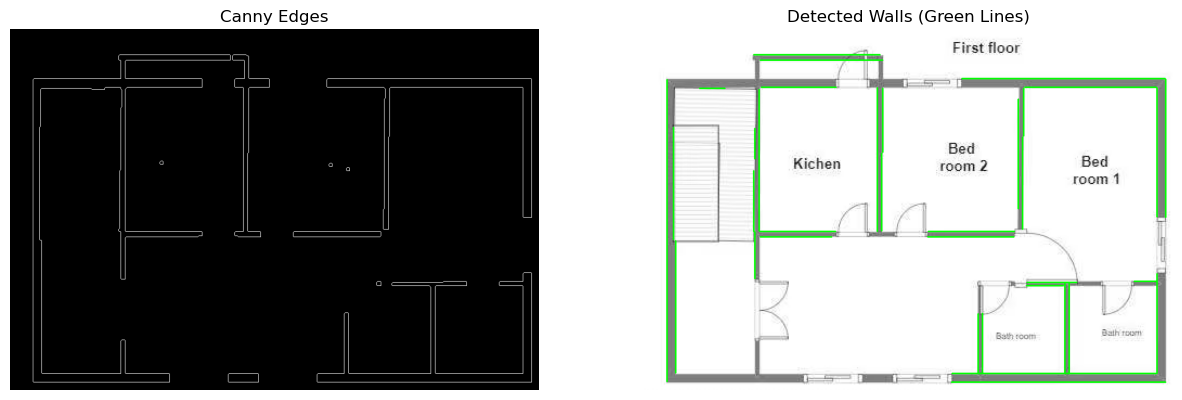

In [4]:
edges = cv2.Canny(bw_clean, 50, 150, apertureSize=3)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                        minLineLength=40, maxLineGap=8)

wall_vis = img_rgb.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(wall_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].imshow(edges, cmap='gray')
axs[0].set_title("Canny Edges")
axs[0].axis("off")

axs[1].imshow(wall_vis)
axs[1].set_title("Detected Walls (Green Lines)")
axs[1].axis("off")

plt.show()




825.0
49.0
11728.5
1445.5
25.0
25.0
25.0
11308.5
3968.0
22108.5


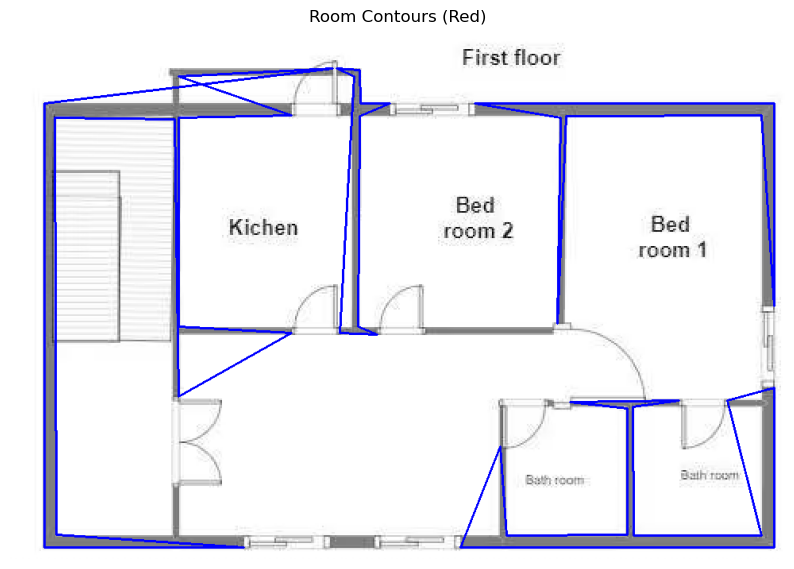

Detected 4 rooms.


In [5]:
# Invert image so rooms = white
inv = cv2.bitwise_not(bw_clean)

contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for c in contours:
    area = cv2.contourArea(c)
    print(area)
    if area < 2000:   # ignore small specks
        continue
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.drawContours(room_vis, [approx], -1, (0,0,255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Room Contours (Red)")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


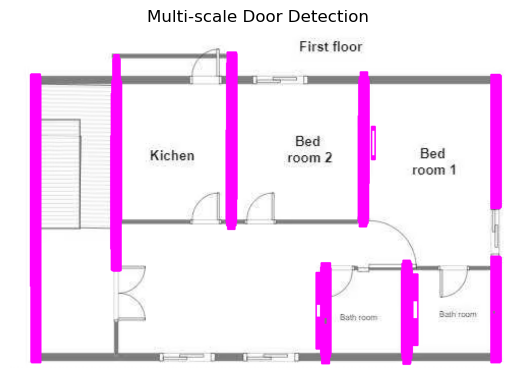

In [6]:
door_t = cv2.imread("data/door2.png", cv2.IMREAD_GRAYSCALE)
door_t = cv2.resize(door_t, None, fx=0.8, fy=0.8)

plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
res = cv2.matchTemplate(plan_gray, door_t, cv2.TM_CCOEFF_NORMED)
yy, xx = np.where(res > 0.65)  # adjust threshold

door_vis = img_rgb.copy()
scales = [0.5, 0.75, 1.0, 1.25]
all_matches = []

for s in scales:
    temp = cv2.resize(door_t, None, fx=s, fy=s)
    res = cv2.matchTemplate(plan_gray, temp, cv2.TM_CCOEFF_NORMED)
    yy, xx = np.where(res > 0.7)
    h, w = temp.shape[:2]
    for (x, y) in zip(xx, yy):
        all_matches.append((x, y, w, h))

door_vis = img_rgb.copy()
for (x, y, w, h) in all_matches:
    cv2.rectangle(door_vis, (x, y), (x+w, y+h), (255, 0, 255), 2)

plt.imshow(door_vis)
plt.title("Multi-scale Door Detection")
plt.axis("off")
plt.show()
